In [286]:
import polars as pl
pl.Config.set_tbl_cols(-1)# 列表示を省略しない
#pl.Config.set_tbl_rows(-1)# 行の表示を省略しない
import polars.selectors as cs#列選択のプリセット

# １章 ウェブの注文数を分析する１０本ノック

### ノック１：データを読み込んでみよう
まずデータを読み込んで、データの概観を確認します。

In [287]:
customer_master = pl.read_csv("customer_master.csv")
customer_master.head()

customer_id,customer_name,registration_date,customer_name_kana,email,gender,age,birth,pref
str,str,str,str,str,str,i64,str,str
"""IK152942""","""平田 裕次郎""","""2019-01-01 00:…","""ひらた ゆうじろう""","""hirata_yuujiro…","""M""",29,"""1990/6/10""","""石川県"""
"""TS808488""","""田村 詩織""","""2019-01-01 01:…","""たむら しおり""","""tamura_shiori@…","""F""",33,"""1986/5/20""","""東京都"""
"""AS834628""","""久野 由樹""","""2019-01-01 02:…","""ひさの ゆき""","""hisano_yuki@ex…","""F""",63,"""1956/1/2""","""茨城県"""
"""AS345469""","""鶴岡 薫""","""2019-01-01 04:…","""つるおか かおる""","""tsuruoka_kaoru…","""M""",74,"""1945/3/25""","""東京都"""
"""GD892565""","""大内 高史""","""2019-01-01 04:…","""おおうち たかし""","""oouchi_takashi…","""M""",54,"""1965/8/5""","""千葉県"""


顧客情報のデータです。顧客ID、顧客名、登録日、ひらがな入力の名前、メールアドレス、性別、年齢、誕生日、都道府県の9列あります。

In [288]:
item_master = pl.read_csv("item_master.csv")
item_master.head()

item_id,item_name,item_price
str,str,i64
"""S001""","""PC-A""",50000
"""S002""","""PC-B""",85000
"""S003""","""PC-C""",120000
"""S004""","""PC-D""",180000
"""S005""","""PC-E""",210000


商品情報のデータです。商品ID、標品名、商品価格の3列あります。

In [289]:
transaction_1 = pl.read_csv("transaction_1.csv")
transaction_1.head()

transaction_id,price,payment_date,customer_id
str,i64,str,str
"""T0000000113""",210000,"""2019-02-01 01:…","""PL563502"""
"""T0000000114""",50000,"""2019-02-01 01:…","""HD678019"""
"""T0000000115""",120000,"""2019-02-01 02:…","""HD298120"""
"""T0000000116""",210000,"""2019-02-01 02:…","""IK452215"""
"""T0000000117""",170000,"""2019-02-01 04:…","""PL542865"""


購入明細データです。購入明細ID、価格、購入日、顧客IDの4列あります。

In [290]:
transaction_detail_1 = pl.read_csv("transaction_detail_1.csv")
transaction_detail_1.head()

detail_id,transaction_id,item_id,quantity
i64,str,str,i64
0,"""T0000000113""","""S005""",1
1,"""T0000000114""","""S001""",1
2,"""T0000000115""","""S003""",1
3,"""T0000000116""","""S005""",1
4,"""T0000000117""","""S002""",2


購入明細の詳細データです。詳細ID、購入明細ID、商品ID、購入数の4列あります。

### ノック２：データを結合(ユニオン)してみよう
ファイルサイズの制限で2つ以上のファイルに分割されていたので、購入明細データを縦に結合します。

In [291]:
transaction_2 = pl.read_csv("transaction_2.csv")
transaction = pl.concat(items = [transaction_1, transaction_2])
transaction.head()

transaction_id,price,payment_date,customer_id
str,i64,str,str
"""T0000000113""",210000,"""2019-02-01 01:…","""PL563502"""
"""T0000000114""",50000,"""2019-02-01 01:…","""HD678019"""
"""T0000000115""",120000,"""2019-02-01 02:…","""HD298120"""
"""T0000000116""",210000,"""2019-02-01 02:…","""IK452215"""
"""T0000000117""",170000,"""2019-02-01 04:…","""PL542865"""


結合前後のレコード数を確認して、結合処理が正しく行われたことを確認します。

In [292]:
print( len(transaction_1) )
print( len(transaction_2) )
print( len(transaction) )

5000
1786
6786


購入明細の詳細データでも同様に縦に結合して、レコード数を確認します。

In [293]:
transaction_detail_2 = pl.read_csv("transaction_detail_2.csv")
transaction_detail = pl.concat(items = [transaction_detail_1, transaction_detail_2])
transaction_detail.head()

detail_id,transaction_id,item_id,quantity
i64,str,str,i64
0,"""T0000000113""","""S005""",1
1,"""T0000000114""","""S001""",1
2,"""T0000000115""","""S003""",1
3,"""T0000000116""","""S005""",1
4,"""T0000000117""","""S002""",2


In [294]:
print( len(transaction_detail_1) )
print( len(transaction_detail_2) )
print( len(transaction_detail) )

5000
2144
7144


### ノック３：売上データ同士を結合(ジョイン)してみよう
今度はデータを横に結合します。\
横に結合するときは、粒度が細かいデータに粗いデータを結合していくことを意識します。\
粒度とはデータの示す情報の細かさです。

顧客情報と商品情報は最も粒度が粗いデータ(ユニーク値)で、次いで購入明細、購入明細の詳細の順に粒度が細かくなるので、今回は購入明細の詳細にデータを結合していきます。

* 顧客情報
  * ユニーク値
* 商品情報
  * ユニーク値
* 購入明細
  * どの顧客が、いつ、いくら購入したのか
* 購入明細の詳細
  * 購入時に、どの商品を、何個購入したのか

どの列をキーに結合するかを確認します。

In [295]:
print(transaction_detail.columns)
print(transaction.columns)

['detail_id', 'transaction_id', 'item_id', 'quantity']
['transaction_id', 'price', 'payment_date', 'customer_id']


"transaction_id" をキーにしてデータを結合します。\
ただし、購入明細データの "price" を結合すると二重計上が発生するので除外します。

In [296]:
join_data = transaction_detail.join(other = transaction.drop(columns = "price"), on = "transaction_id", how = "left")
join_data.head()

detail_id,transaction_id,item_id,quantity,payment_date,customer_id
i64,str,str,i64,str,str
0,"""T0000000113""","""S005""",1,"""2019-02-01 01:…","""PL563502"""
1,"""T0000000114""","""S001""",1,"""2019-02-01 01:…","""HD678019"""
2,"""T0000000115""","""S003""",1,"""2019-02-01 02:…","""HD298120"""
3,"""T0000000116""","""S005""",1,"""2019-02-01 02:…","""IK452215"""
4,"""T0000000117""","""S002""",2,"""2019-02-01 04:…","""PL542865"""


"price"を除外せずに結合した場合の総額が、元のデータの総額よりも増えています。\
これが二重計上であり、データを結合するときは注意してください。

In [297]:
print(transaction["price"].sum())
print(transaction_detail.join(other = transaction, on = "transaction_id", how = "left")["price"].sum())

971135000
1074750000


横結合前後のレコード数・列数を確認します。

In [298]:
print( transaction_detail.shape )
print( transaction.shape )
print( join_data.shape )

(7144, 4)
(6786, 4)
(7144, 6)


購入明細の詳細データに対して、列が増えた結果になりました。\
(右側に"transaction_id"キーが複数あった場合、レコード数も増えます)

### ノック４：マスタデータを結合(ジョイン)してみよう

購入明細に、顧客情報と商品情報を横結合していきます。\
各データの列名ｗ表示して、結合キーを表示します。

In [299]:
print(join_data.columns)
print(customer_master.columns)
print(item_master.columns)

['detail_id', 'transaction_id', 'item_id', 'quantity', 'payment_date', 'customer_id']
['customer_id', 'customer_name', 'registration_date', 'customer_name_kana', 'email', 'gender', 'age', 'birth', 'pref']
['item_id', 'item_name', 'item_price']


顧客情報と結合する時は、"customer_id"キーで、商品情報と結合する時は"item_id"キーで結合します。

In [300]:
join_data = (
    join_data
    .join(other = customer_master, on = "customer_id", how = "left")
    .join(other = item_master, on = "item_id", how = "left")
)
join_data.head()

detail_id,transaction_id,item_id,quantity,payment_date,customer_id,customer_name,registration_date,customer_name_kana,email,gender,age,birth,pref,item_name,item_price
i64,str,str,i64,str,str,str,str,str,str,str,i64,str,str,str,i64
0,"""T0000000113""","""S005""",1,"""2019-02-01 01:…","""PL563502""","""井本 芳正""","""2019-01-07 14:…","""いもと よしまさ""","""imoto_yoshimas…","""M""",30,"""1989/7/15""","""熊本県""","""PC-E""",210000
1,"""T0000000114""","""S001""",1,"""2019-02-01 01:…","""HD678019""","""三船 六郎""","""2019-01-27 18:…","""みふね ろくろう""","""mifune_rokurou…","""M""",73,"""1945/11/29""","""京都府""","""PC-A""",50000
2,"""T0000000115""","""S003""",1,"""2019-02-01 02:…","""HD298120""","""山根 小雁""","""2019-01-11 08:…","""やまね こがん""","""yamane_kogan@e…","""M""",42,"""1977/5/17""","""茨城県""","""PC-C""",120000
3,"""T0000000116""","""S005""",1,"""2019-02-01 02:…","""IK452215""","""池田 菜摘""","""2019-01-10 05:…","""いけだ なつみ""","""ikeda_natsumi@…","""F""",47,"""1972/3/17""","""兵庫県""","""PC-E""",210000
4,"""T0000000117""","""S002""",2,"""2019-02-01 04:…","""PL542865""","""栗田 憲一""","""2019-01-25 06:…","""くりた けんいち""","""kurita_kenichi…","""M""",74,"""1944/12/17""","""長崎県""","""PC-B""",85000


### ノック5：必要なデータ列を作ろう

売上推移の分析のためにデータを結合してきましたが、購入明細データを結合する時に"price"列(購入明細ごとの売り上げ)を削除しました。\
そこで、商品ごとの購入数と商品価格の積から、購入明細の詳細ごとの売り上げを計算します。 

In [301]:
join_data = (
    join_data.with_columns([
        (join_data["quantity"] * join_data["item_price"]).alias("price")
    ])
)
join_data[["quantity", "item_price", "price"]].head()

quantity,item_price,price
i64,i64,i64
1,210000,210000
1,50000,50000
1,120000,120000
1,210000,210000
2,85000,170000


### ノック6：データ検算をしよう

データの加工前後の売上の総額は同じであると期待されます。\
そこで、加工前後の売上総額を検算します。

In [302]:
print( join_data["price"].sum() )
print( transaction["price"].sum() )

971135000
971135000


等号で確認することもできます。

In [303]:
join_data["price"].sum() == transaction["price"].sum()

True

### ノック7：各種統計量を把握しよう

欠損値は分析に悪影響を与えることが多いので、まず欠損値の有無を確認します。

In [304]:
join_data.null_count()

detail_id,transaction_id,item_id,quantity,payment_date,customer_id,customer_name,registration_date,customer_name_kana,email,gender,age,birth,pref,item_name,item_price,price
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


欠損値が無いことがわかったので、このデータの各種統計量を計算します。\
pandasと同じ結果を得るために polars.selectors を使用します。

In [305]:
join_data.select(cs.numeric()).describe()

describe,detail_id,quantity,age,item_price,price
str,f64,f64,f64,f64,f64
"""count""",7144.0,7144.0,7144.0,7144.0,7144.0
"""null_count""",0.0,0.0,0.0,0.0,0.0
"""mean""",3571.5,1.199888,50.265677,121698.628219,135937.150056
"""std""",2062.439494,0.513647,17.190314,64571.31183,68511.453297
"""min""",0.0,1.0,20.0,50000.0,50000.0
"""25%""",1786.0,1.0,36.0,50000.0,85000.0
"""50%""",3572.0,1.0,50.0,120000.0,120000.0
"""75%""",5357.0,1.0,65.0,180000.0,210000.0
"""max""",7143.0,4.0,80.0,210000.0,420000.0


数値データとは別に気になる情報として、どの期間の売り上げデータであるかを確認します。

In [306]:
print( join_data["payment_date"].min() )
print( join_data["payment_date"].max() )

2019-02-01 01:36:57
2019-07-31 23:41:38


### ノック8：月別でデータを集計してみよう

全体の数字感を把握したので、次は時系列で状況を見ていきましょう。\
各列のデータ型を確認します。\
polarsはデータを表示する時に列名とデータ型が表示されるので、head()メソッドでデータ型を確認します。

In [307]:
#join_data.dtypes
join_data.head(n = 1)

detail_id,transaction_id,item_id,quantity,payment_date,customer_id,customer_name,registration_date,customer_name_kana,email,gender,age,birth,pref,item_name,item_price,price
i64,str,str,i64,str,str,str,str,str,str,str,i64,str,str,str,i64,i64
0,"""T0000000113""","""S005""",1,"""2019-02-01 01:…","""PL563502""","""井本 芳正""","""2019-01-07 14:…","""いもと よしまさ""","""imoto_yoshimas…","""M""",30,"""1989/7/15""","""熊本県""","""PC-E""",210000,210000


payment_dateが文字列になっているので、DateTime型に変換しましょう。\
さらに、時系列の粒度を分析しやすくするために、購入年月の列を作成します。

In [308]:
join_data = (
    join_data
    # 文字列型である"payment_date"をDateTime型に変換する
    .with_columns(
        pl.col("payment_date")
        .str.to_datetime()
        .alias("payment_date")
    )
    # 購入年月データを作成する
    .with_columns(
        pl.col("payment_date")
        .dt.strftime("%Y/%m")
        .alias("payment_month")
    )
)
join_data[["payment_date", "payment_month"]].head()

payment_date,payment_month
datetime[μs],str
2019-02-01 01:36:57,"""201902"""
2019-02-01 01:37:23,"""201902"""
2019-02-01 02:34:19,"""201902"""
2019-02-01 02:47:23,"""201902"""
2019-02-01 04:33:46,"""201902"""


購入年月ごとの売り上げを集計します。

In [309]:
(
    join_data
    .group_by(by = "payment_month")
    .agg( pl.sum("price") )
    .sort(by = "payment_month")
)

payment_month,price
str,i64
"""201902""",160185000
"""201903""",160370000
"""201904""",160510000
"""201905""",155420000
"""201906""",164030000
"""201907""",170620000


### ノック9：月別、商品別でデータを集計してみよう

月別、商品別で売り上げ、販売数量を集計します。\
pandasの方が大項目のセルを結合してくれるので、group_by後の結果を保存する時は、pandasにしておいた方が良い。

In [310]:
(
    join_data
    .group_by(by = ["payment_month", "item_name"])
    .agg( pl.sum("price"), pl.sum("quantity") )
    .sort(by = ["payment_month", "item_name"])
)

payment_month,item_name,price,quantity
str,str,i64,i64
"""201902""","""PC-A""",24150000,483
"""201902""","""PC-B""",25245000,297
"""201902""","""PC-C""",19800000,165
"""201902""","""PC-D""",31140000,173
"""201902""","""PC-E""",59850000,285
"""201903""","""PC-A""",26000000,520
"""201903""","""PC-B""",25500000,300
"""201903""","""PC-C""",19080000,159
"""201903""","""PC-D""",25740000,143


pandasの場合の計算結果を示します。

In [311]:
(
    join_data
    .to_pandas()
    .groupby(by = ["payment_month", "item_name"])
    [["price", "quantity"]]
    .sum()
)

price  quantity
payment_month item_name                    
201902        PC-A       24150000       483
              PC-B       25245000       297
              PC-C       19800000       165
              PC-D       31140000       173
              PC-E       59850000       285
201903        PC-A       26000000       520
              PC-B       25500000       300
              PC-C       19080000       159
              PC-D       25740000       143
              PC-E       64050000       305
201904        PC-A       25900000       518
              PC-B       23460000       276
              PC-C       21960000       183
              PC-D       24300000       135
              PC-E       64890000       309
201905        PC-A       24850000       497
              PC-B       25330000       298
              PC-C       20520000       171
              PC-D       25920000       144
              PC-E       58800000       280
201906        PC-A       26000000       520
              PC-B       23970000       282
              PC-C       21840000       182
              PC-D       28800000       160
              PC-E       63420000       302
201907        PC-A       25250000       505
              PC-B       28220000       332
              PC-C       19440000       162
              PC-D       26100000       145
              PC-E       71610000       341

商品別に、月毎の売り上げと販売数量のピボットテーブルを作成します。

In [312]:
(
    join_data
    .pivot(
        index = "item_name",
        columns = "payment_month",
        values = ["price", "quantity"],
        aggregate_function = "sum",
        sort_columns = True
    )
    .sort(by = "item_name")
)

item_name,price_payment_month_201902,price_payment_month_201903,price_payment_month_201904,price_payment_month_201905,price_payment_month_201906,price_payment_month_201907,quantity_payment_month_201902,quantity_payment_month_201903,quantity_payment_month_201904,quantity_payment_month_201905,quantity_payment_month_201906,quantity_payment_month_201907
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""PC-A""",24150000,26000000,25900000,24850000,26000000,25250000,483,520,518,497,520,505
"""PC-B""",25245000,25500000,23460000,25330000,23970000,28220000,297,300,276,298,282,332
"""PC-C""",19800000,19080000,21960000,20520000,21840000,19440000,165,159,183,171,182,162
"""PC-D""",31140000,25740000,24300000,25920000,28800000,26100000,173,143,135,144,160,145
"""PC-E""",59850000,64050000,64890000,58800000,63420000,71610000,285,305,309,280,302,341


pandasの場合の計算結果を示します。

In [313]:
import pandas as pd
(
    pd
    .pivot_table(
        data = join_data.to_pandas(),
        index = "item_name",
        columns = "payment_month",
        values = ["price", "quantity"],
        aggfunc = "sum"
    )
)

price                                                    \
payment_month    201902    201903    201904    201905    201906    201907   
item_name                                                                   
PC-A           24150000  26000000  25900000  24850000  26000000  25250000   
PC-B           25245000  25500000  23460000  25330000  23970000  28220000   
PC-C           19800000  19080000  21960000  20520000  21840000  19440000   
PC-D           31140000  25740000  24300000  25920000  28800000  26100000   
PC-E           59850000  64050000  64890000  58800000  63420000  71610000   

              quantity                                     
payment_month   201902 201903 201904 201905 201906 201907  
item_name                                                  
PC-A               483    520    518    497    520    505  
PC-B               297    300    276    298    282    332  
PC-C               165    159    183    171    182    162  
PC-D               173    143    135    144    160    145  
PC-E               285    305    309    280    302    341

### ノック10：商品別の売上推移を可視化してみよう

月別、商品別の売上推移をグラフにするために、データを集計します。

In [314]:
graph_data = (
    join_data
    .pivot(
        index = "payment_month",
        columns = "item_name",
        values = "price",
        aggregate_function = "sum",
        sort_columns = True
    )
    .sort("payment_month")
)
graph_data.head()

payment_month,PC-A,PC-B,PC-C,PC-D,PC-E
str,i64,i64,i64,i64,i64
"""201902""",24150000,25245000,19800000,31140000,59850000
"""201903""",26000000,25500000,19080000,25740000,64050000
"""201904""",25900000,23460000,21960000,24300000,64890000
"""201905""",24850000,25330000,20520000,25920000,58800000
"""201906""",26000000,23970000,21840000,28800000,63420000


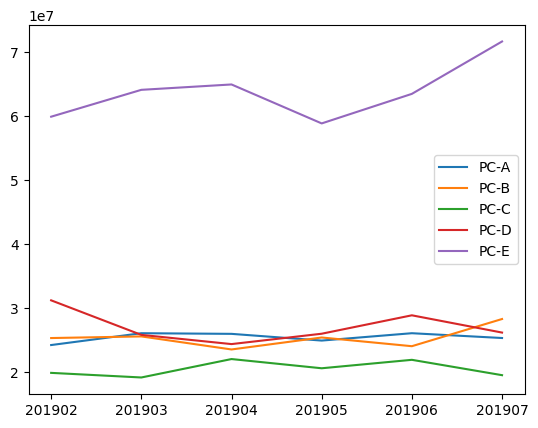

In [315]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(graph_data["payment_month"], graph_data["PC-A"], label = "PC-A")
plt.plot(graph_data["payment_month"], graph_data["PC-B"], label = "PC-B")
plt.plot(graph_data["payment_month"], graph_data["PC-C"], label = "PC-C")
plt.plot(graph_data["payment_month"], graph_data["PC-D"], label = "PC-D")
plt.plot(graph_data["payment_month"], graph_data["PC-E"], label = "PC-E")
plt.legend()